
<p style="text-align: center; font-size: 32px; font-weight: bold;">Analyzing Top 20 S&P 500 Companies by Index Weight</p>

- This script analyzes S&P 500 data to identify the top 20 companies by index weight on the most recent trading day. 

- It calculates each company's historical minimum and maximum stock prices, along with the dates these occurred and the percentage difference between them. 

In [1]:
import pandas as pd
import numpy as np

# Load and preprocess data
df = pd.read_csv('output/s&p500_merged.csv', sep=';', dtype="str")
df.columns = df.columns.str.strip()
df['Weight'] = df['Weight'].str.replace('%', '', regex=False).astype(float)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])

# Latest snapshot
latest_date = df['Date'].max()
latest_df = df[df['Date'] == latest_date].drop_duplicates(subset='Symbol')
top_20 = latest_df.sort_values(by='Weight', ascending=False).head(20)

top_symbols = top_20['Symbol'].tolist()
symbol_to_weight = top_20.set_index('Symbol')['Weight'].to_dict()
symbol_to_company = top_20.set_index('Symbol')['Company'].to_dict()

top_df = df[df['Symbol'].isin(top_symbols)]
grouped = top_df.groupby('Symbol')

# Compute min/max info
min_max_info = []
for symbol in top_symbols:
    company_data = grouped.get_group(symbol)
    min_row = company_data.loc[company_data['Price'].idxmin()]
    max_row = company_data.loc[company_data['Price'].idxmax()]

    min_price = min_row['Price']
    max_price = max_row['Price']
    abs_diff = max_price - min_price
    pct_diff = ((abs_diff) / min_price * 100) if min_price > 0 else 0

    min_max_info.append({
        'Symbol': symbol,
        'Company': symbol_to_company[symbol],
        'Weight': symbol_to_weight[symbol],
        'min_price': min_price,
        'min_date': min_row['Date'].date(),
        'max_price': max_price,
        'max_date': max_row['Date'].date(),
        'abs_diff': abs_diff,
        'pct_diff': pct_diff
    })

info_df = pd.DataFrame(min_max_info)


- This code generates a horizontal bar chart visualizing the top 20 S&P 500 companies by index weight. 

- Each bar is color-coded based on the percentage difference between the company’s historical minimum and maximum stock prices. 

- Annotations next to each bar display the min/max prices with dates and their difference. 

- A colorbar provides a reference scale for price volatility, and separator lines improve readability between entries.

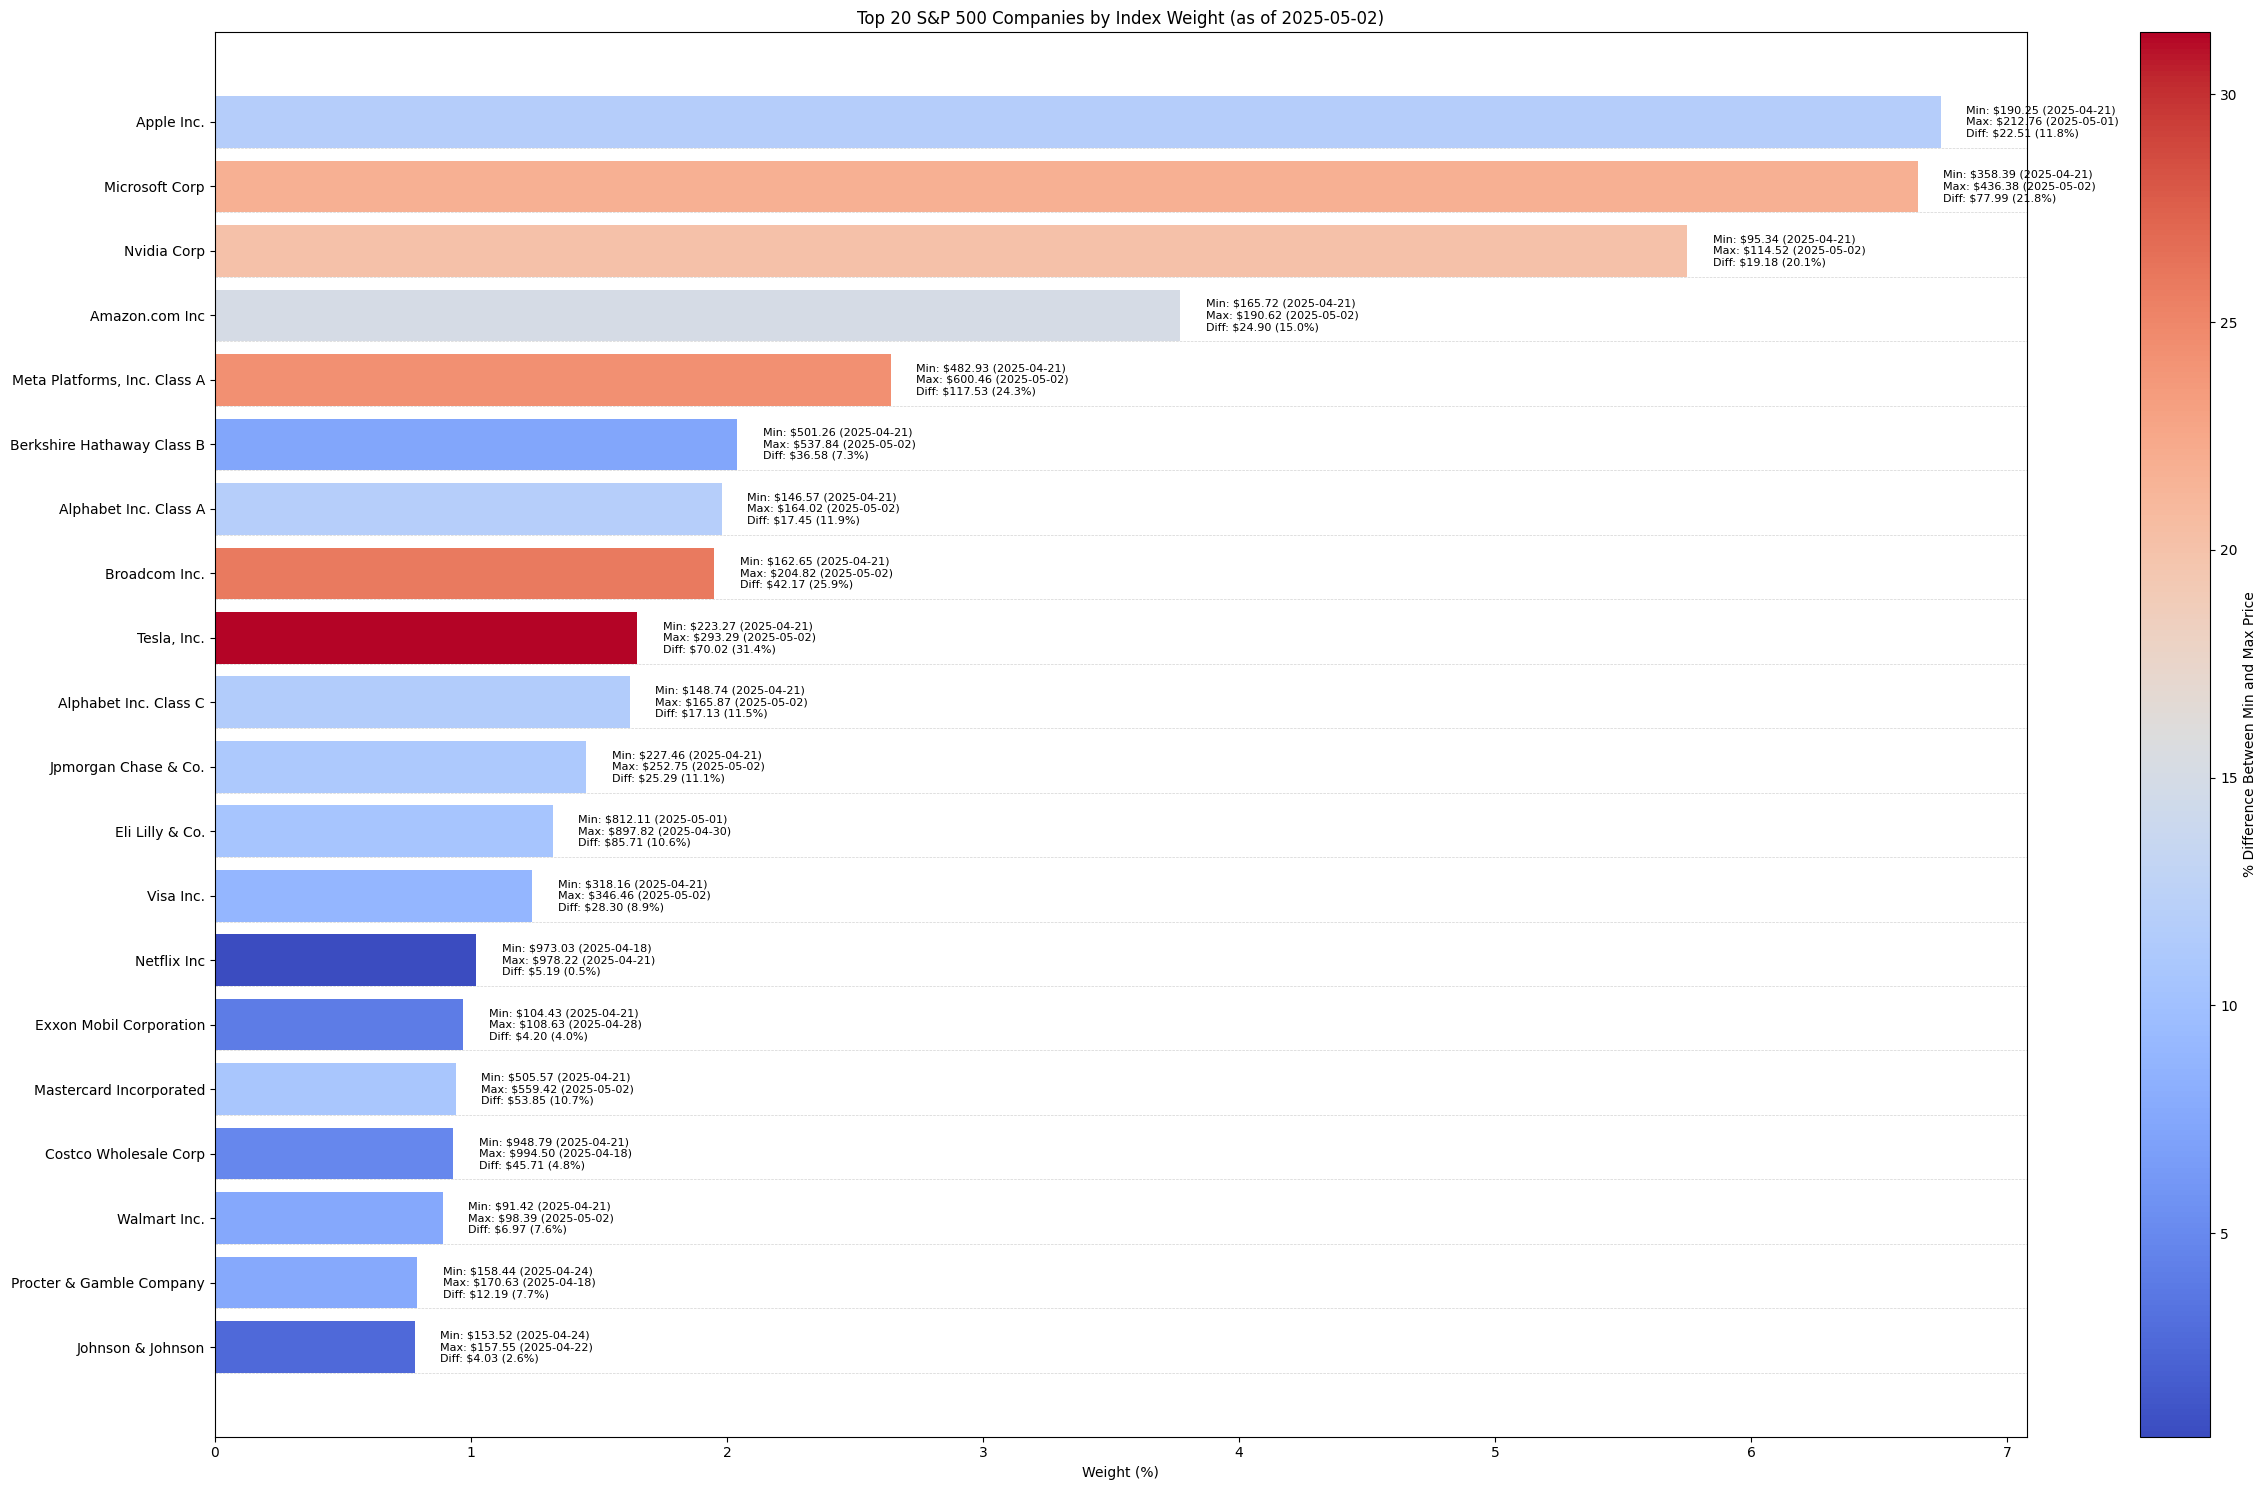

In [2]:
import matplotlib.pyplot as plt

# Normalize % diff for color mapping
norm = plt.Normalize(vmin=info_df['pct_diff'].min(), vmax=info_df['pct_diff'].max())
colors = plt.cm.coolwarm(norm(info_df['pct_diff'])) 

# Plotting
plt.figure(figsize=(25, 15))
bars = plt.barh(info_df['Company'], info_df['Weight'], color=colors)
plt.xlabel("Weight (%)")
plt.title(f"Top 20 S&P 500 Companies by Index Weight (as of {latest_date.date()})")
plt.gca().invert_yaxis()

# Annotations
for bar, (_, row) in zip(bars, info_df.iterrows()):
    y_pos = bar.get_y() + bar.get_height() / 2
    plt.text(bar.get_width() + 0.1, y_pos,
             f"Min: ${row['min_price']:.2f} ({row['min_date']})\n"
             f"Max: ${row['max_price']:.2f} ({row['max_date']})\n"
             f"Diff: ${row['abs_diff']:.2f} ({row['pct_diff']:.1f}%)",
             va='center', ha='left', fontsize=8)

# Separator lines
ax = plt.gca()
for bar in bars:
    ax.axhline(y=bar.get_y() + bar.get_height(), color='lightgray', linestyle='--', linewidth=0.5)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('% Difference Between Min and Max Price')

plt.tight_layout()
plt.show()
